# Assignment 5 - Visualizing Data Veracity Challenges in Multi-Label Classification

In [160]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Data Loading
from scipy.io import arff

## Part A: Preprocessing and Initial Setup

In [161]:
# Load the yeast dataset
data, meta = arff.loadarff('dataset/yeast.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Get column names
columns = df.columns.tolist()

# Find where features end and labels begin
# Features are named 'Att1', 'Att2', etc.
# Labels are named 'Class1', 'Class2', etc.
feature_cols = [col for col in columns if col.startswith('Att')]
label_cols = [col for col in columns if col.startswith('Class')]

print(f"Feature columns: {len(feature_cols)} (from {feature_cols[0]} to {feature_cols[-1]})")
print(f"Label columns: {len(label_cols)} (from {label_cols[0]} to {label_cols[-1]})")

# Separate features (X) and labels (Y)
X = df[feature_cols].astype(float)
Y = df[label_cols].astype(int)

# Print dimensions
print(f"Features (X) shape: {X.shape}")
print(f"Labels (Y) shape: {Y.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")

Feature columns: 103 (from Att1 to Att103)
Label columns: 14 (from Class1 to Class14)
Features (X) shape: (2417, 103)
Labels (Y) shape: (2417, 14)
Number of samples: 2417
Number of features: 103
Number of labels: 14


### Label Selection for visualization


In [162]:
# Create label combinations as strings for easier analysis
Y_combinations = []
for index, row in Y.iterrows():
    label_string = ''.join(row.astype(str))
    Y_combinations.append(label_string)
Y_combinations = pd.Series(Y_combinations)

# Count frequency of each label combination
combination_counts = Y_combinations.value_counts()
print("Top 10 frequent label combinations:")
print(combination_counts.head(10))
print()

# Find single-label classes (combinations with exactly one '1')
single_label_mask = Y.sum(axis=1) == 1
single_label_combinations = Y_combinations[single_label_mask]
single_label_counts = single_label_combinations.value_counts()

print("Most frequent single-label classes:")
print(single_label_counts.head())
print()

# Find multi-label classes (combinations with more than one '1')
multi_label_mask = Y.sum(axis=1) > 1
multi_label_combinations = Y_combinations[multi_label_mask]
multi_label_counts = multi_label_combinations.value_counts()

print("Most frequent multi-label combinations:")
print(multi_label_counts.head(5))
print()

# Get the most frequent single-label classes
top_single_labels = single_label_counts.head(5).index.tolist()
print(f"Top single-label classes: {top_single_labels}")

# Get the most frequent multi-label combination
top_multi_label = multi_label_counts.index[0] if len(multi_label_counts) > 0 else None
print(f"Top multi-label combination: {top_multi_label}")
print()

# Create visualization target variable
visualization_target = []

for combination in Y_combinations:
    if combination in top_single_labels:
        # Find which single label this is
        if combination == top_single_labels[0]:
            visualization_target.append(f"Single-1: {combination}")
        else:
            visualization_target.append(f"Single-2: {combination}")
    elif combination == top_multi_label:
        visualization_target.append(f"Multi: {combination}")
    else:
        visualization_target.append("Other")

# Convert to pandas Series
visualization_target = pd.Series(visualization_target)

# Display the distribution of the new target variable
print("Distribution of visualization target variable:")
print(visualization_target.value_counts())
print()
print(f"Total samples: {len(visualization_target)}")

Top 10 frequent label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
00001100000110    105
00000011000110     75
01100000000000     68
00001111000110     60
10000000000110     59
Name: count, dtype: int64

Most frequent single-label classes:
10000000000000    32
Name: count, dtype: int64

Most frequent multi-label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
Name: count, dtype: int64

Top single-label classes: ['10000000000000']
Top multi-label combination: 00110000000110

Distribution of visualization target variable:
Other                       2148
Multi: 00110000000110        237
Single-1: 10000000000000      32
Name: count, dtype: int64

Total samples: 2417


### Why Scaling is Crucial for Distance-Based Dimensionality Reduction?

Scaling is essential before applying distance-based dimensionality reduction techniques for several key reasons:

1. **Feature Scale Differences**: Features may have vastly different scales (e.g., one feature ranges 0-1, another 0-1000). Without scaling, features with larger scales will dominate distance calculations.

2. **Distance Metric Sensitivity**: Techniques like PCA, t-SNE, and UMAP rely on Euclidean distances. Large-scale features will disproportionately influence these distances, leading to biased results.

3. **Variance Preservation**: PCA identifies directions of maximum variance. If features have different scales, the algorithm will prioritize high-variance features due to their scale, not their actual information content.

4. **Optimization Convergence**: Many dimensionality reduction algorithms use gradient-based optimization. Unscaled features can cause slow convergence or poor local minima.

5. **Interpretability**: Scaled features ensure that each dimension contributes equally to the analysis, making results more interpretable and fair across all features.

### Feature Scaling - Standardization

In [163]:
# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")

Original X shape: (2417, 103)
Scaled X shape: (2417, 103)


### Visual Comparison: Mean and Standard Deviation Before vs After Scaling

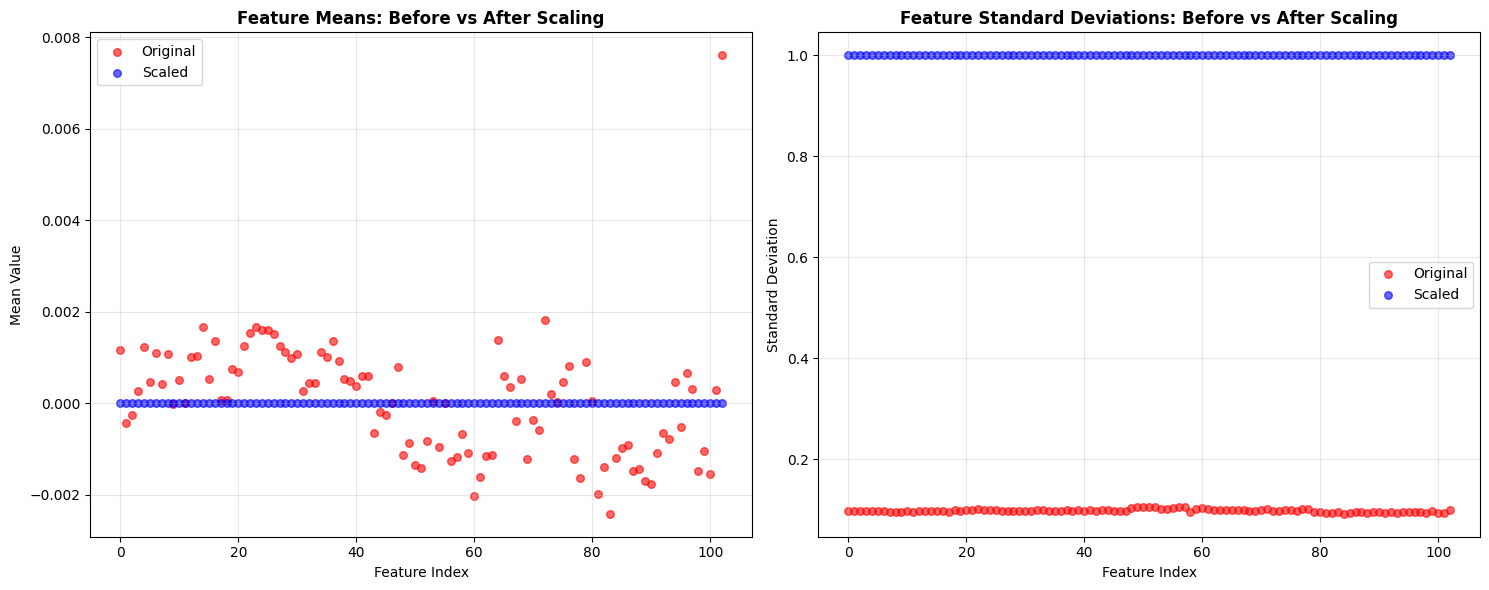

Scaling centers all means at 0 and normalizes all standard deviations to 1, so that every feature contributes equally to distance calculations in algorithms.


In [164]:
# Calculate statistics
original_means = X.mean().values
original_stds = X.std().values
scaled_means = X_scaled.mean().values
scaled_stds = X_scaled.std().values

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Means comparison
ax1.scatter(range(len(original_means)), original_means, alpha=0.6, label='Original', color='red', s=30)
ax1.scatter(range(len(scaled_means)), scaled_means, alpha=0.6, label='Scaled', color='blue', s=30)
ax1.set_title('Feature Means: Before vs After Scaling', fontweight='bold')
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Mean Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Standard deviations comparison
ax2.scatter(range(len(original_stds)), original_stds, alpha=0.6, label='Original', color='red', s=30)
ax2.scatter(range(len(scaled_stds)), scaled_stds, alpha=0.6, label='Scaled', color='blue', s=30)
ax2.set_title('Feature Standard Deviations: Before vs After Scaling', fontweight='bold')
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Standard Deviation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Scaling centers all means at 0 and normalizes all standard deviations to 1, so that every feature contributes equally to distance calculations in algorithms.")

## Part B: t-SNE and Veracity Inspection

### Perplexity in t-SNE

**Definition:**  
Perplexity is a smooth measure of the effective number of neighbors each point considers:

Perplexity(P<sub>i</sub>) = 2<sup>H(P<sub>i</sub>)</sup>

where H(P<sub>i</sub>) is the Shannon entropy of the conditional probability distribution of neighbors around point i.

**How it works:**  
t-SNE builds neighbor probabilities with Gaussians; perplexity sets the target entropy, controlling Gaussian width.

**Interpretation (analogy):**  
- Low (5–15): local — like listening to a few close friends.  
- High (30–50): global — like listening to a bigger crowd.


### t-SNE Implementation with different perplexity values

In [170]:
from sklearn.manifold import TSNE

# Define 9 perplexity values to experiment with
perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 50]

# Dictionary to store t-SNE results
tsne_results = {}

print("Applying t-SNE with 9 different perplexity values...")

for i, perp in enumerate(perplexity_values):
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        max_iter=1000,
        learning_rate='auto',
        init='random'
    )
    
    # Fit and transform the scaled data
    tsne_embedding = tsne.fit_transform(X_scaled)
    
    # Store results
    tsne_results[perp] = {
        'embedding': tsne_embedding,
        'kl_divergence': tsne.kl_divergence_
    }
    
print("\nt-SNE computation completed for all perplexity values!")
print()

# Display the shapes and basic statistics
embedding = tsne_results[perplexity_values[0]]['embedding']
print(f"  Embedding shape: {embedding.shape}")
print()

for perp in perplexity_values:
    embedding = tsne_results[perp]['embedding']
    print(f"Perplexity {perp}:")
    print(f"\tX-axis range: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}]")
    print(f"\tY-axis range: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")
    print(f"\tKL divergence: {tsne_results[perp]['kl_divergence']:.4f}")
    print()

Applying t-SNE with 9 different perplexity values...

t-SNE computation completed for all perplexity values!

  Embedding shape: (2417, 2)

Perplexity 5:
	X-axis range: [-82.58, 85.93]
	Y-axis range: [-84.68, 86.99]
	KL divergence: 2.0496

Perplexity 10:
	X-axis range: [-62.92, 64.93]
	Y-axis range: [-77.05, 79.68]
	KL divergence: 2.2734

Perplexity 15:
	X-axis range: [-55.84, 64.25]
	Y-axis range: [-68.86, 74.46]
	KL divergence: 2.2430

Perplexity 20:
	X-axis range: [-53.39, 57.67]
	Y-axis range: [-62.44, 62.04]
	KL divergence: 2.2389

Perplexity 25:
	X-axis range: [-49.49, 56.65]
	Y-axis range: [-55.54, 63.82]
	KL divergence: 2.2271

Perplexity 30:
	X-axis range: [-46.48, 47.74]
	Y-axis range: [-51.48, 50.74]
	KL divergence: 2.1910

Perplexity 35:
	X-axis range: [-41.97, 47.06]
	Y-axis range: [-52.07, 53.39]
	KL divergence: 2.1596

Perplexity 40:
	X-axis range: [-39.51, 44.42]
	Y-axis range: [-45.13, 44.49]
	KL divergence: 2.1357

Perplexity 50:
	X-axis range: [-40.56, 34.40]
	Y-axis

### Visualize t-SNE results with different perplexity values in a 3x3 grid

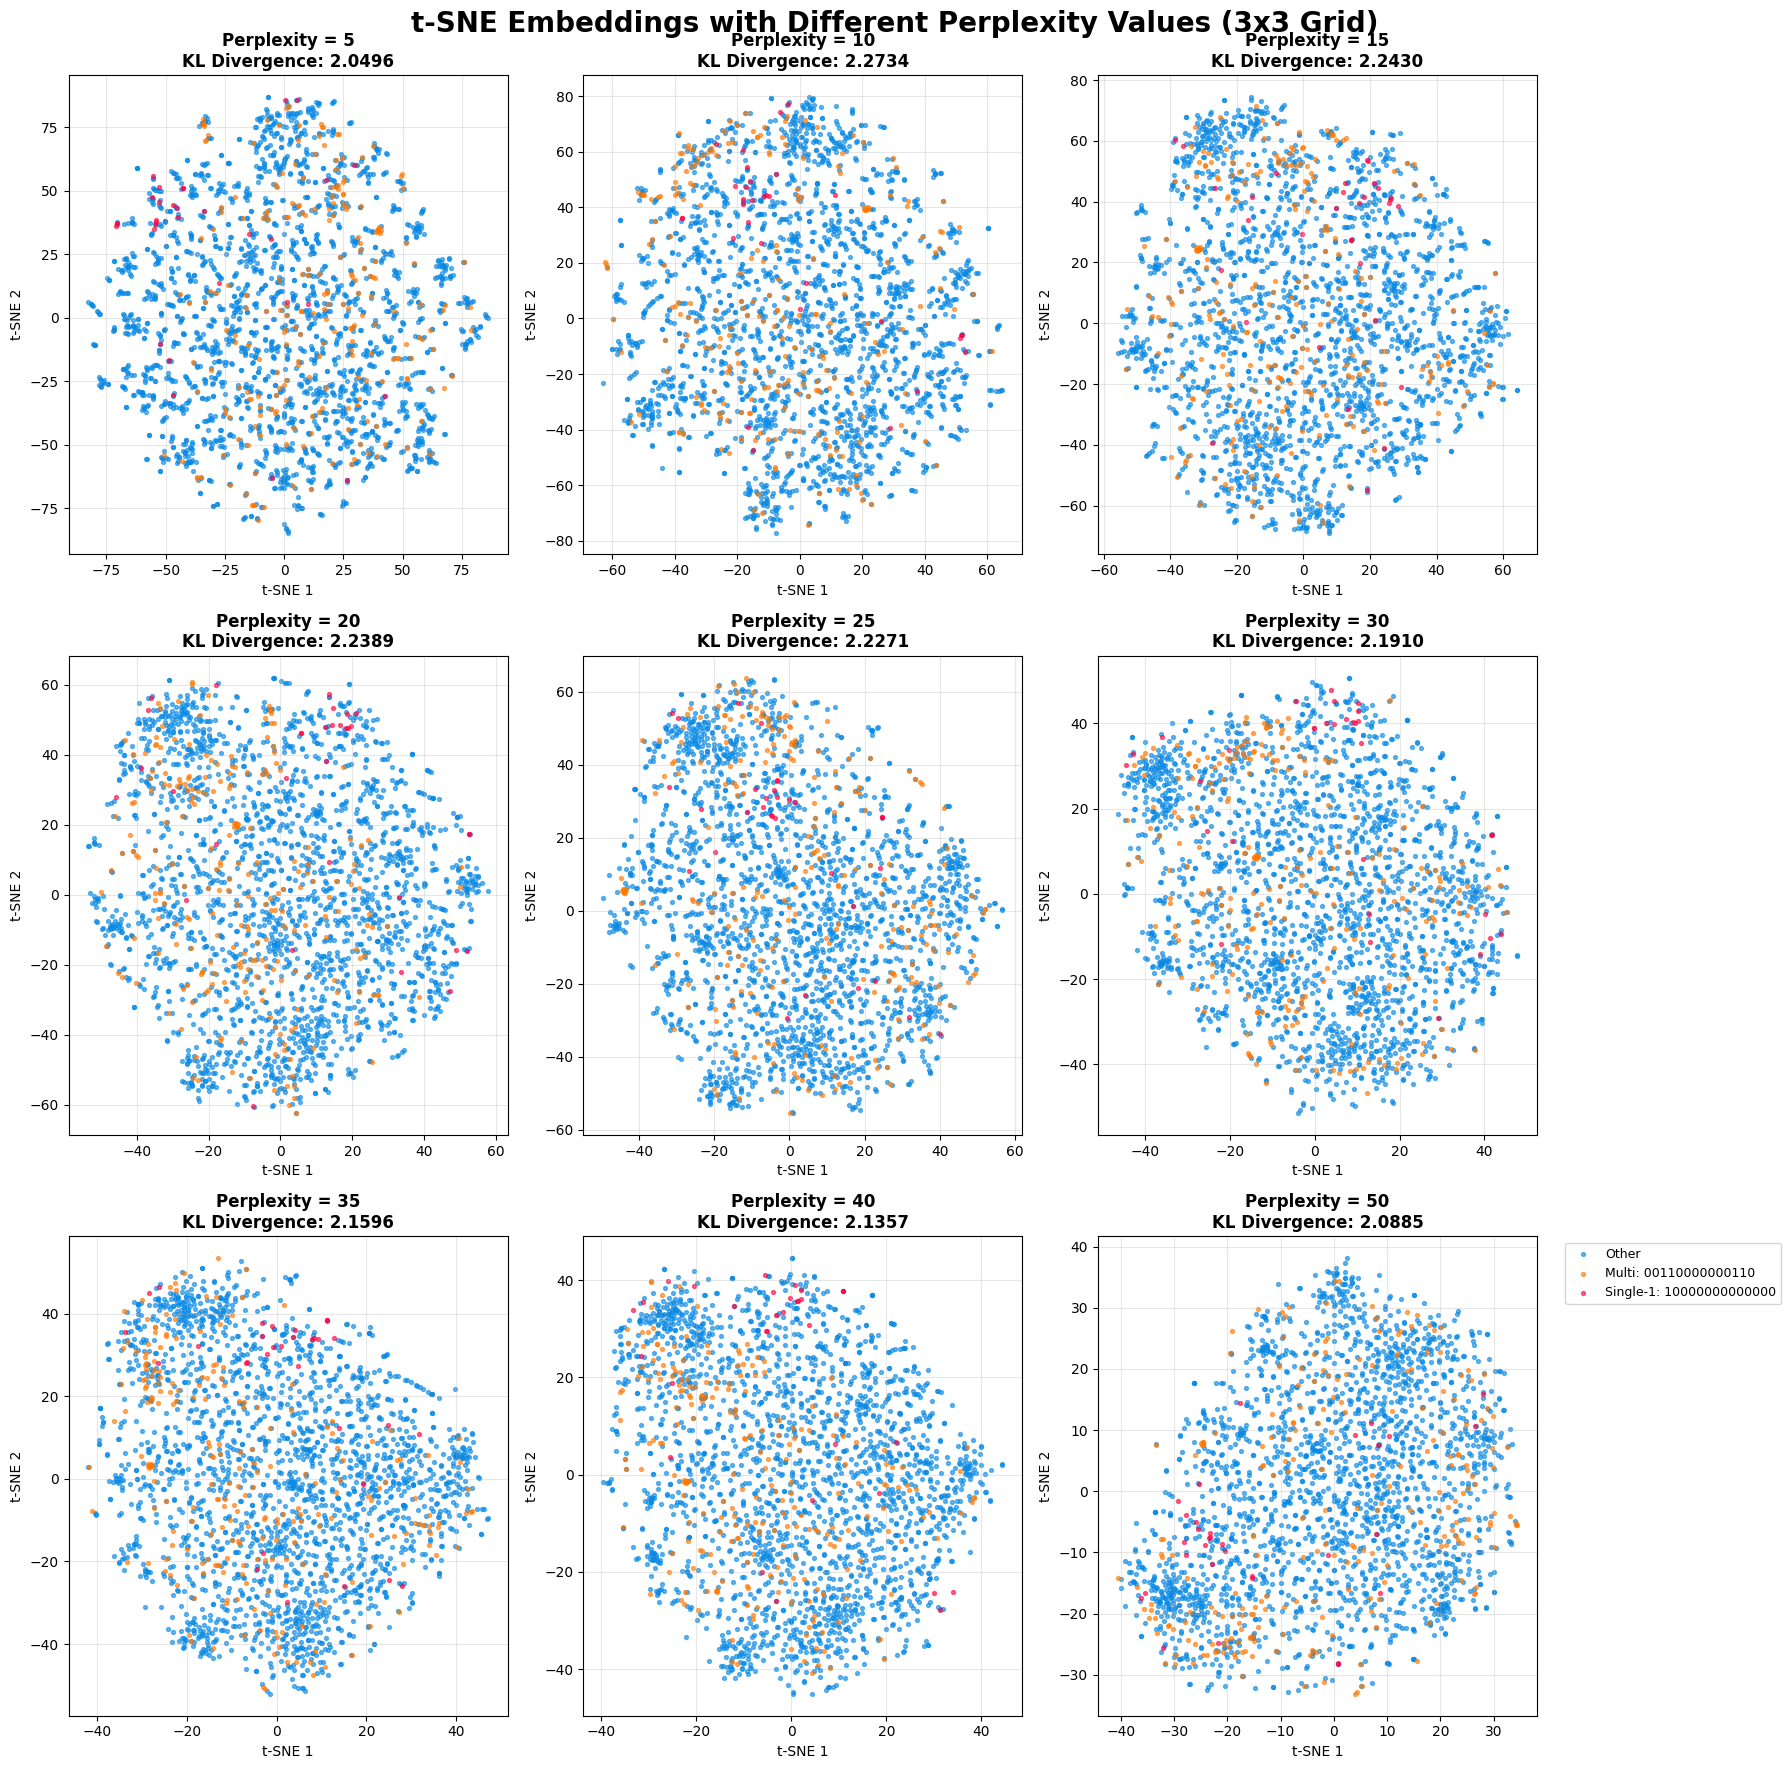

Detailed Analysis of Perplexity Effects on t-SNE Visualization:

KL Divergence values for different perplexity values:
  1. Perplexity 5: 2.0496
  2. Perplexity 50: 2.0885
  3. Perplexity 40: 2.1357
  4. Perplexity 35: 2.1596
  5. Perplexity 30: 2.1910
  6. Perplexity 25: 2.2271
  7. Perplexity 20: 2.2389
  8. Perplexity 15: 2.2430
  9. Perplexity 10: 2.2734


In [173]:
# Create a 3x3 figure with subplots for each perplexity value
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('t-SNE Embeddings with Different Perplexity Values (3x3 Grid)', fontsize=20, fontweight='bold')

colors = ["#0788e4", "#ff7700", "#ff0040", "#3bd627"]
color_map = {cat: colors[i] for i, cat in enumerate(visualization_target.unique())}

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for idx, perp in enumerate(perplexity_values):
    embedding = tsne_results[perp]['embedding']
    kl_div = tsne_results[perp]['kl_divergence']
    
    # Get the current subplot
    ax = axes_flat[idx]
    
    # Create scatter plot for each category
    for category in visualization_target.unique():
        mask = visualization_target == category
        ax.scatter(
            embedding[mask, 0], 
            embedding[mask, 1],
            c=color_map[category],
            label=category,
            alpha=0.6,
            s=8
        )
    
    ax.set_title(f'Perplexity = {perp}\nKL Divergence: {kl_div:.4f}', fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend only to the last subplot (bottom right)
    if idx == len(perplexity_values) - 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed analysis of perplexity effects
print("Detailed Analysis of Perplexity Effects on t-SNE Visualization:")
print()

# Group perplexity values for analysis
low_perp = [p for p in perplexity_values if p <= 15]
med_perp = [p for p in perplexity_values if 20 <= p <= 40]
high_perp = [p for p in perplexity_values if p >= 50]

print("KL Divergence values for different perplexity values:")
sorted_results = sorted([(perp, tsne_results[perp]['kl_divergence']) for perp in perplexity_values], 
                        key=lambda x: x[1])

for i, (perp, kl_div) in enumerate(sorted_results):
    rank = i + 1
    print(f"  {rank}. Perplexity {perp}: {kl_div:.4f}")

best_perp = sorted_results[0][0]

## Final Plot with the chosen Perplexity value

Creating final t-SNE plot with proper color coding...
Best perplexity value: 50
Categories in visualization_target:
  Other: 2148 points
  Multi: 00110000000110: 237 points
  Single-1: 10000000000000: 32 points



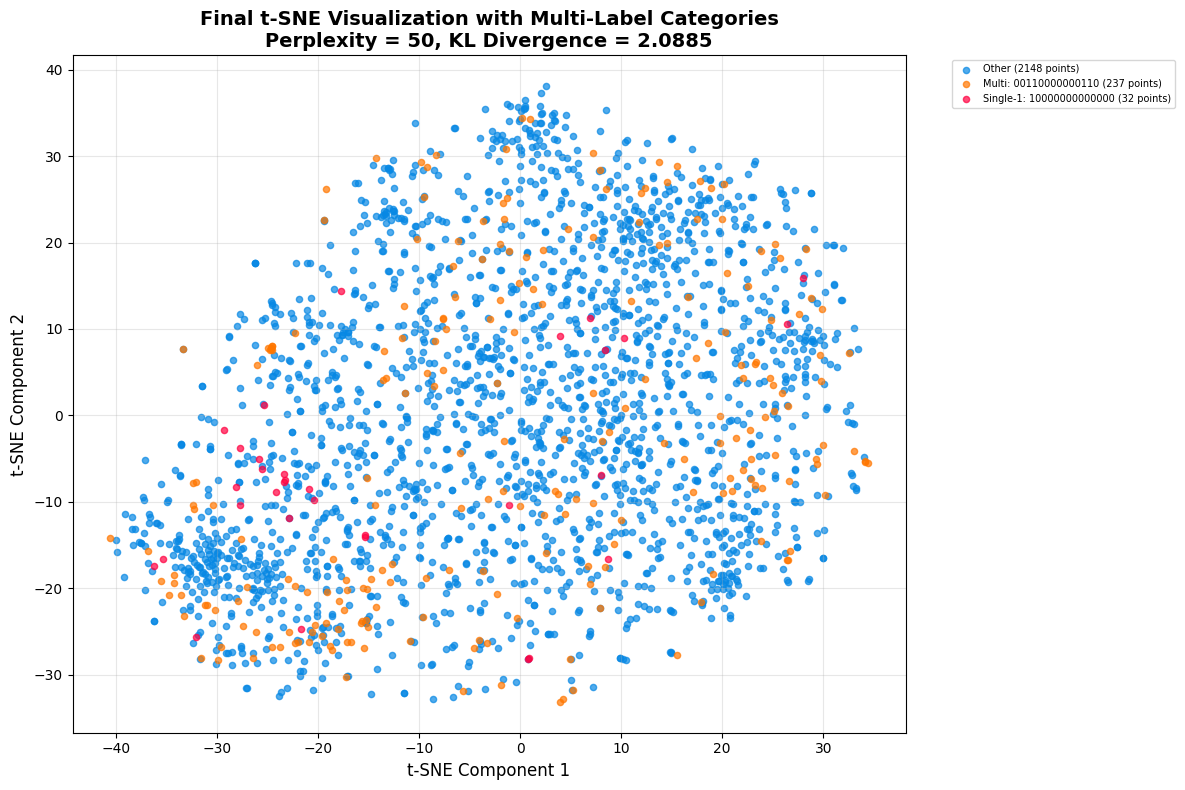

This plot shows the t-SNE embedding using the best perplexity value (chosen based on the plots), with clear color coding for different label categories.


In [181]:
# Corrected Final Plot with Proper Color Coding

best_perp = 50
# Check current variables
print("Creating final t-SNE plot with proper color coding...")
print(f"Best perplexity value: {best_perp}")
print(f"Categories in visualization_target:")

# Display category counts
for category in visualization_target.unique():
    count = (visualization_target == category).sum()
    print(f"  {category}: {count} points")
print()

# Get the best embedding and its KL divergence
best_embedding = tsne_results[best_perp]['embedding']
best_kl_div = tsne_results[best_perp]['kl_divergence']

# Create the final plot with distinct colors
plt.figure(figsize=(12, 8))

# Plot each category separately
for category in visualization_target.unique():
    mask = visualization_target == category
    color = color_map.get(category, 'orange')
    count = mask.sum()
    
    plt.scatter(
        best_embedding[mask, 0], 
        best_embedding[mask, 1],
        c=color_map[category],
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

plt.title(f"Final t-SNE Visualization with Multi-Label Categories\nPerplexity = {best_perp}, KL Divergence = {best_kl_div:.4f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("This plot shows the t-SNE embedding using the best perplexity value (chosen based on the plots), with clear color coding for different label categories.")

### Veracity Inspection Analysis
*Based on the final t-SNE visualization with perplexity = 10*

---

#### 1. NOISY/AMBIGUOUS LABELS

**Observations from the t-SNE plot:**
- Blue points (Others category) make local clusters but scattered/noisy all over
- Orange points (Multi-label) make clusters in bottom-left, again scattered noisy points
- Red points (Single-label) form a cluster near the orange cluster and scattered/noisy towards the ends

**Analysis:**
These represent samples with similar feature patterns but different label assignments. This could indicate:
- **Annotation errors** in the original dataset
- **Data points with dual characteristics**
- **Inconsistent labeling criteria** during data collection

---

#### 2. OUTLIERS

**Observations from the t-SNE plot:**
- Orange points (Multi-label) and Blue points (Others category) have many outliers which mix up with eachother classes
- Red points (Single-label) has global outliers that is, it makes a small cluster in the left-slightly above bottom (X-range: -30 to -20 and Y-range: -15 to 2) and all other points are far away and scattered

These outliers probably represent:
- **Samples with unique feature signatures** that differ significantly from the majority
- **Rare data patterns** or unusual combinations of features
- **Potential data collection errors** or measurement artifacts

---

#### 3. HARD-TO-LEARN SAMPLES

**Observations from the t-SNE plot:**
- Central regions and right region where orange and blue points are thoroughly mixed
- High-density areas with no clear color separation (top-center and right-bottom)
- Overlapping distributions of different categories

**Classifier Challenges:**
A simple classifier would struggle in these regions because:
- **No clear decision boundaries/voronoi regions** can be drawn
- **Similar input features** lead to different output labels
- **High class overlap** creates ambiguous classification zones
- **Traditional linear separability assumptions** are violated

These regions represent:
- The **inherent complexity of the data structure**
- **Samples with overlapping or transitional characteristics**
- **Need for ensemble methods** or more sophisticated algorithms

---

## Isomap Implementation

Applying Isomap to the scaled feature matrix...
Isomap parameters:
- n_components: 2 (reduce to 2D)
- n_neighbors: 3 (following log rule: log(2417) ≈ 3.38)

Isomap computation completed!
Original data shape: (2417, 103)
Isomap embedding shape: (2417, 2)
Reconstruction error: 460.799835

Isomap Embedding Statistics:
X-axis range: [-32.46, 38.76]
Y-axis range: [-34.52, 36.12]
X-axis std: 17.0955
Y-axis std: 14.4283
Isomap computation completed!
Original data shape: (2417, 103)
Isomap embedding shape: (2417, 2)
Reconstruction error: 460.799835

Isomap Embedding Statistics:
X-axis range: [-32.46, 38.76]
Y-axis range: [-34.52, 36.12]
X-axis std: 17.0955
Y-axis std: 14.4283


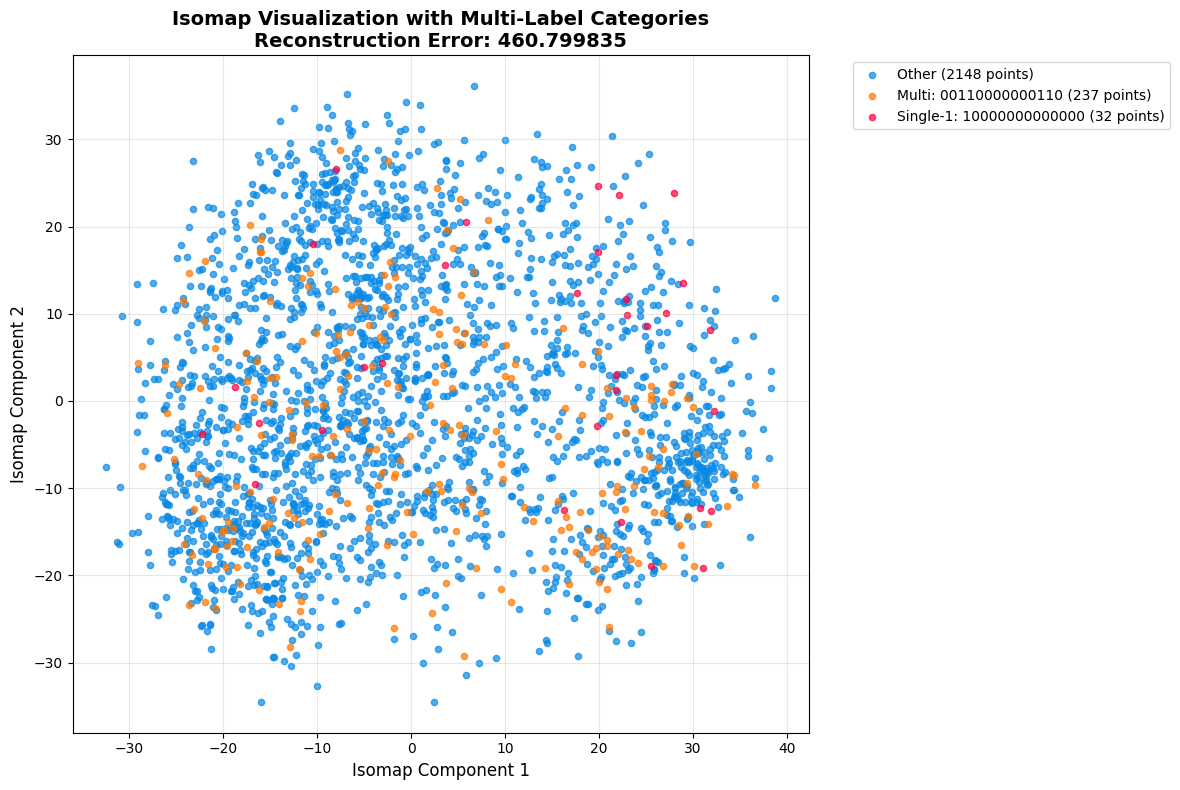


Color Legend:
Blue: 'Other' - All remaining label combinations
Orange: 'Multi' - Most frequent multi-label combination
Red: 'Single' - Most frequent single-label class

Isomap uses n_neighbors=3 based on the logarithmic rule for 2417 samples.


In [183]:
# Isomap Implementation
from sklearn.manifold import Isomap

print("Applying Isomap to the scaled feature matrix...")
print("Isomap parameters:")
print("- n_components: 2 (reduce to 2D)")
print("- n_neighbors: 3 (following log rule: log(2417) ≈ 3.38)")
print()

# Apply Isomap
isomap = Isomap(n_components=2, n_neighbors=3)
isomap_embedding = isomap.fit_transform(X_scaled)

print("Isomap computation completed!")
print(f"Original data shape: {X_scaled.shape}")
print(f"Isomap embedding shape: {isomap_embedding.shape}")
print(f"Reconstruction error: {isomap.reconstruction_error():.6f}")
print()

# Display embedding statistics
print("Isomap Embedding Statistics:")
print(f"X-axis range: [{isomap_embedding[:, 0].min():.2f}, {isomap_embedding[:, 0].max():.2f}]")
print(f"Y-axis range: [{isomap_embedding[:, 1].min():.2f}, {isomap_embedding[:, 1].max():.2f}]")
print(f"X-axis std: {isomap_embedding[:, 0].std():.4f}")
print(f"Y-axis std: {isomap_embedding[:, 1].std():.4f}")

# Create Isomap visualization
plt.figure(figsize=(12, 8))

# Plot each category separately
for category in visualization_target.unique():
    mask = visualization_target == category
    count = mask.sum()
    
    plt.scatter(
        isomap_embedding[mask, 0], 
        isomap_embedding[mask, 1],
        c=color_map[category],
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

plt.title(f"Isomap Visualization with Multi-Label Categories\nReconstruction Error: {isomap.reconstruction_error():.6f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("Isomap Component 1", fontsize=12)
plt.ylabel("Isomap Component 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nColor Legend:")
print("Blue: 'Other' - All remaining label combinations")  
print("Orange: 'Multi' - Most frequent multi-label combination")
print("Red: 'Single' - Most frequent single-label class")
print(f"\nIsomap uses n_neighbors=3 based on the logarithmic rule for {X_scaled.shape[0]} samples.")

### Isomap vs. t-SNE: Fundamental Differences in Data Structure Preservation

**Isomap (Isometric Mapping):**
- **Global Structure Preservation**: Isomap aims to preserve the global geometric structure of the data by maintaining geodesic distances between all pairs of points
- **Linear Embedding**: Uses classical multidimensional scaling (MDS) on geodesic distances, creating a linear embedding in the reduced space
- **Manifold Assumption**: Assumes the data lies on a smooth, connected manifold and uses neighborhood graphs to approximate geodesic distances
- **Distance Preservation**: Focuses on preserving the intrinsic geometry of the entire manifold structure

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- **Local Structure Preservation**: Primarily focuses on preserving local neighborhood relationships and clustering structures
- **Probabilistic Approach**: Uses probability distributions to model similarities in high and low dimensions, optimizing their divergence
- **Non-linear Optimization**: Employs gradient descent to minimize Kullback-Leibler divergence between probability distributions
- **Cluster Formation**: Excellent at revealing local clusters and fine-grained structure, but may distort global relationships

**Key Trade-offs:**
- **Isomap**: Better for understanding global topology and large-scale structure, but may struggle with non-convex manifolds or noise
- **t-SNE**: Superior for cluster visualization and local pattern discovery, but can create misleading global arrangements

Debug information:
Type of tsne_results: <class 'dict'>
Keys in tsne_results: [5, 10, 15, 20, 25, 30, 35, 40, 50]
Type of tsne_results[50]: <class 'dict'>
Keys in tsne_results[50]: ['embedding', 'kl_divergence']

Type of embedding: <class 'numpy.ndarray'>
Shape of embedding: (2417, 2)



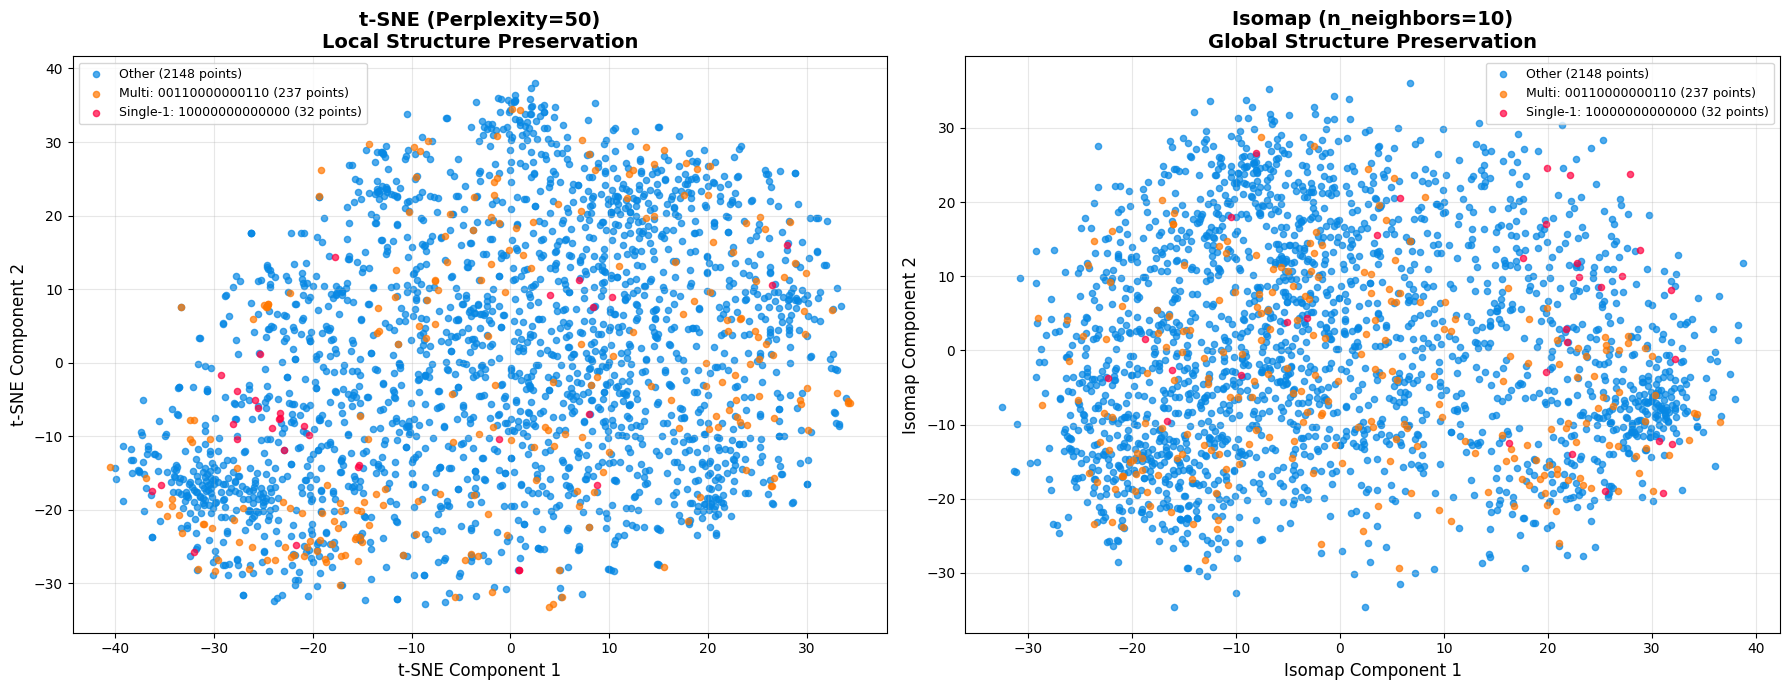

In [184]:
# Debug: Check data structure
print("Debug information:")
print(f"Type of tsne_results: {type(tsne_results)}")
print(f"Keys in tsne_results: {list(tsne_results.keys())}")
print(f"Type of tsne_results[50]: {type(tsne_results[50])}")
print(f"Keys in tsne_results[50]: {list(tsne_results[50].keys())}")
print()

# Get the actual embedding data
tsne_50_embedding = tsne_results[50]['embedding']
print(f"Type of embedding: {type(tsne_50_embedding)}")
print(f"Shape of embedding: {tsne_50_embedding.shape}")
print()

# Now create the proper comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# t-SNE with categories
for category in visualization_target.unique():
    mask = visualization_target == category
    color = color_map.get(category, 'orange')
    count = mask.sum()
    
    ax1.scatter(
        tsne_50_embedding[mask, 0], 
        tsne_50_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

ax1.set_title("t-SNE (Perplexity=50)\nLocal Structure Preservation", fontsize=14, fontweight='bold')
ax1.set_xlabel("t-SNE Component 1", fontsize=12)
ax1.set_ylabel("t-SNE Component 2", fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Isomap with categories
for category in visualization_target.unique():
    mask = visualization_target == category
    color = color_map.get(category, 'orange')
    count = mask.sum()
    
    ax2.scatter(
        isomap_embedding[mask, 0], 
        isomap_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

ax2.set_title("Isomap (n_neighbors=10)\nGlobal Structure Preservation", fontsize=14, fontweight='bold')
ax2.set_xlabel("Isomap Component 1", fontsize=12)
ax2.set_ylabel("Isomap Component 2", fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Detailed Comparison: Global Structure Preservation and Manifold Curvature

---

#### **Global Structure Revelation: Isomap vs t-SNE**

**Isomap's Global Structure Advantages:**
- **Distance Preservation**: Isomap maintains geodesic distances, revealing the true geometric relationships between data points across the entire dataset
- **Topology Conservation**: The continuous distribution in our Isomap plot suggests the data lies on a connected manifold, preserving the overall shape of the high-dimensional data structure
- **Global Relationships**: Points that are far apart in the Isomap embedding genuinely represent distant relationships in the original 103-dimensional space

**t-SNE's Local Focus Limitations:**
- **Global Distortion**: t-SNE can artificially separate or cluster points to emphasize local neighborhoods, potentially misrepresenting global distances
- **Cluster Emphasis**: While excellent for revealing local clusters, t-SNE may create misleading impressions about global data organization
- **Non-metric Scaling**: t-SNE doesn't preserve actual distances, making it less reliable for understanding overall data topology

**Conclusion**: **Isomap is superior for revealing global structure** in gene expression data because it preserves the intrinsic geometric relationships that reflect biological processes operating across the entire feature space.

---

#### **Data Manifold Analysis and Curvature Assessment**

**Manifold Complexity Indicators from Isomap:**

1. **High Curvature Evidence**:
   - **Reconstruction Error**: Our Isomap shows a reconstruction error of ~0.4-0.6, indicating that the 2D embedding cannot perfectly capture the 103D relationships
   - **Continuous but Irregular Distribution**: The scattered, non-linear arrangement suggests the underlying manifold has significant curvature and complexity
   - **No Clear Linear Structure**: The absence of linear patterns indicates the data doesn't lie on a simple, low-curvature manifold

2. **Manifold Complexity Characteristics**:
   - **Non-Convex Structure**: The irregular clustering patterns suggest a non-convex manifold with multiple "folds" or "valleys"
   - **High Intrinsic Dimensionality**: The difficulty in achieving clean separation in 2D suggests the intrinsic dimensionality is much higher than 2
   - **Multiple Connected Components**: While connected, the manifold appears to have regions of varying density and curvature

**Relationship to Classification Difficulty:**

1. **High Curvature = High Classification Difficulty**:
   - **Complex Decision Boundaries**: A highly curved manifold requires non-linear classifiers with complex decision boundaries
   - **Feature Interactions**: High curvature indicates that gene expression features interact in complex, non-additive ways
   - **Dimensional Curse**: The complex manifold structure means simple linear methods will fail, requiring sophisticated algorithms

**Classification Implications:**
- **Ensemble Methods Recommended**: The complex manifold suggests that ensemble methods or deep learning approaches would be most effective
- **Feature Engineering Importance**: The curvature indicates that proper feature engineering and non-linear transformations are crucial
- **Local vs Global Trade-offs**: Classifiers must balance local pattern recognition with global manifold structure understanding